In [35]:
import pandas as pd
import numpy as np
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from dateutil.parser import parse as parse_datetime
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

random_seed = np.random.seed()
%matplotlib inline

In [36]:
CATEGORY_ID = 1098

PLOT_X_RATIO = 16
PLOT_Y_RATIO = 9

GRAPH_PLOT_PX_X = 2000
GRAPH_PLOT_PX_Y = round((GRAPH_PLOT_PX_X / PLOT_X_RATIO) * PLOT_Y_RATIO)
DPI = 120

In [37]:
def figure(title: str) -> Figure:
    fig = plt.figure(figsize=(GRAPH_PLOT_PX_X / DPI, GRAPH_PLOT_PX_Y / DPI), dpi=DPI)

    fig.suptitle(
        title,
        fontweight="bold",
    )

    return fig

In [ ]:
# Load Marktplaats dataset

df = pd.read_csv(
    "../../data/listings.csv",
    converters={
        "category_verticals": ast.literal_eval,
        "types": ast.literal_eval,
        "services": ast.literal_eval,
        "image_urls": ast.literal_eval,
    },
)

print(f"Total listings: {len(df.index)}")
df.sample(3)

df = df.drop_duplicates(subset=["item_id"], keep="last", ignore_index=True)
print(f"Total listings with duplicates removed: {len(df.index)}")

Total listings: 21402
Total listings with duplicates removed: 21402


In [39]:
# Only use parent_category_id 1098 (Services and Professionals)

df = df.loc[df["parent_category_id"] == CATEGORY_ID]
print(f"Remaining listings: {len(df.index)}")

Remaining listings: 21402


In [40]:
# Remove irelevant categories: 1198 (Geld en Leningen), 1097 (Hypotheek en Verzekeringen)
REMOVE_CHILD_CATEGORY_IDS: list[int] = [1198, 1097]

df = df[df.child_category_id.isin(REMOVE_CHILD_CATEGORY_IDS) == False]

print(f"Remaining listings: {len(df.index)}")

Remaining listings: 21350


In [41]:
# Check advert types frequency

ad_type_df = df["ad_type"].value_counts().rename_axis("ad_type").reset_index(name="frequency")

print(ad_type_df)

       ad_type  frequency
0  RegularPaid      20657
1   ViaPartner        512
2  RegularFree         36


In [42]:
# Remove "ViaPartner" advert types
df = df[df.ad_type != "ViaPartner"]

print(f"Remaining listings: {len(df.index)}")

Remaining listings: 20838


<Axes: ylabel='Count'>

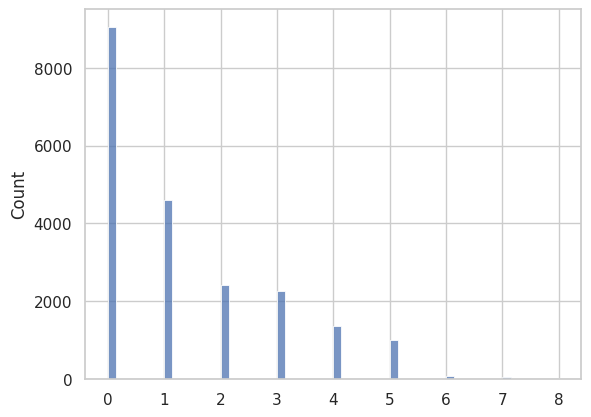

In [43]:
#  Count number of types per listing
types_count_listings = []

for _, listing in df.iterrows():
    types_count = len(listing.types)
    types_count_listings.append(types_count)

sns.histplot(data=types_count_listings)

In [44]:
# get listings with associated types

has_types_df = df[df.types != ()]

# Get types frequency

types_df = pd.DataFrame(
    [str(t) for types_tuple in df["types"] for t in types_tuple], columns=["type"]
)

types_df = types_df["type"].value_counts().rename_axis("type").reset_index(name="frequency")
types_df.set_index("type", inplace=True)
types_freq_dict = types_df["frequency"].to_dict()
types_df.reset_index(inplace=True)

print(f"Number of types: {len(types_df.index)}")

types_df.sample(3)

Number of types: 315


,type,frequency
77,Verzorging of Verzorgpony's,106
119,Hobby of Vrije tijd,59
49,Schoonmaken woning,146


In [45]:
categories_df = pd.DataFrame(
    [categories_tuple[0] for categories_tuple in df["category_verticals"]], columns=["category"]
)

categories_df = (
    categories_df["category"].value_counts().rename_axis("category").reset_index(name="frequency")
)
categories_df["name"] = categories_df.apply(
    lambda row: " ".join(row.category.split("_")).title(), axis=1
)

categories_df.set_index("name", inplace=True)
categories_freq_dict = categories_df["frequency"].to_dict()
categories_df.reset_index(inplace=True)


print(f"Number of categories: {len(categories_df.index)}")

categories_df.sample(3)

Number of categories: 89


,name,category,frequency
51,Translators Interpreters And Copywriters,translators_interpreters_and_copywriters,85
15,Couriers Drivers Taxis,couriers_drivers_taxis,445
64,Pest Control,pest_control,44


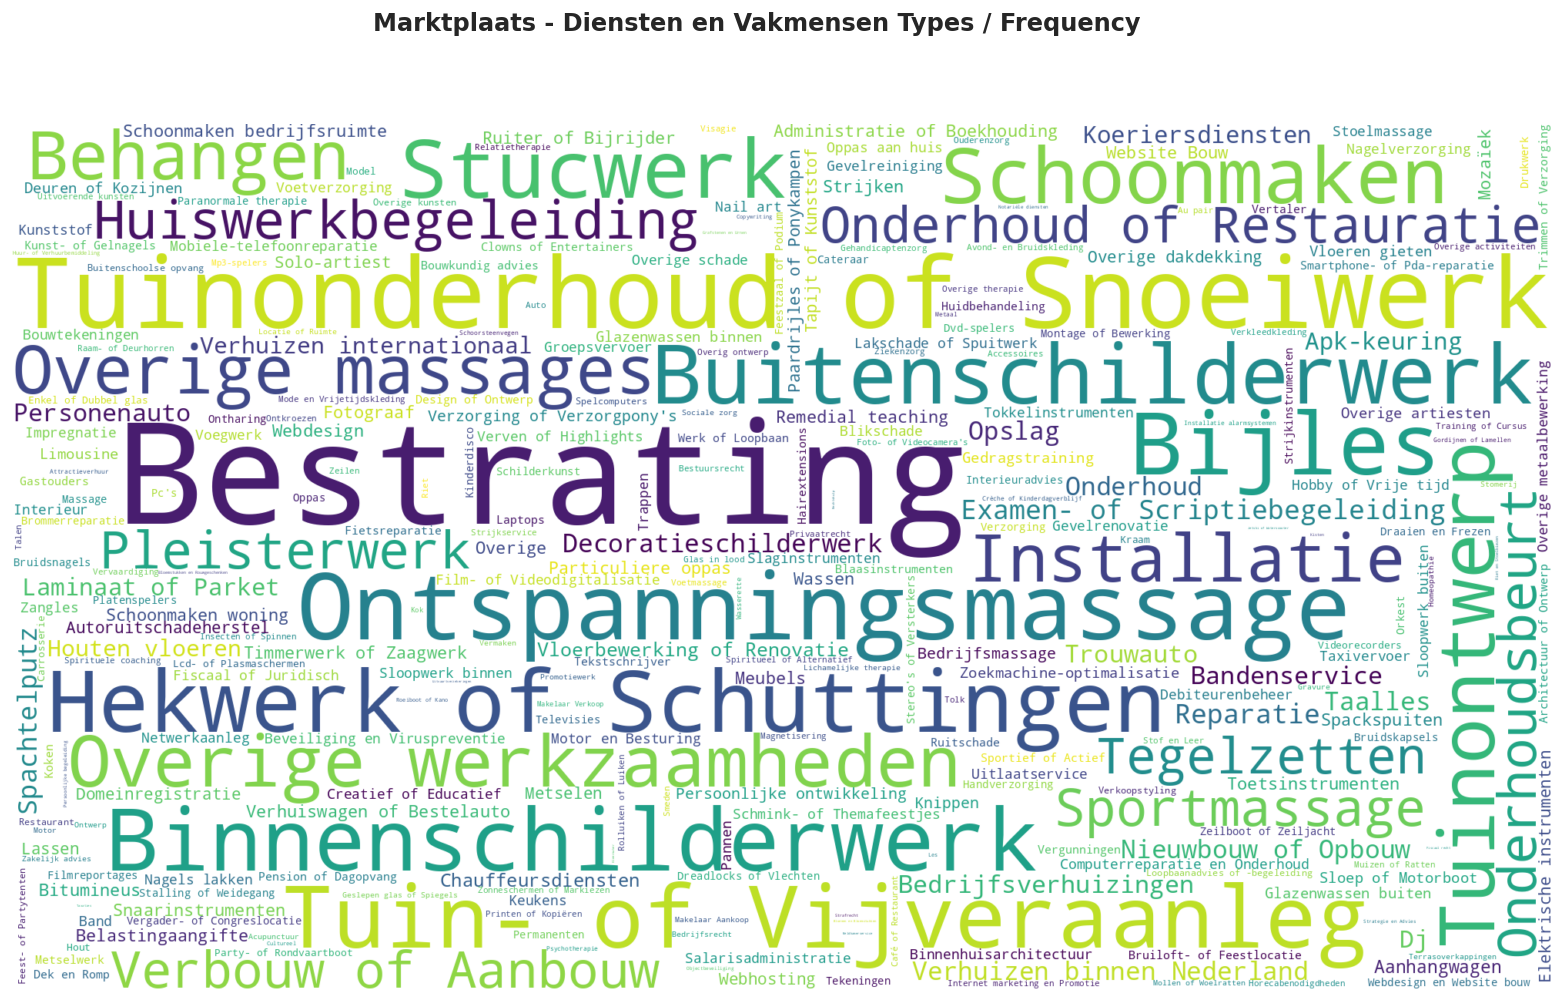

In [46]:
# Generate world cloud of types by frequency

wc = WordCloud(
    width=GRAPH_PLOT_PX_X,
    height=GRAPH_PLOT_PX_Y,
    background_color="white",
    max_words=len(types_df.index),
)

wc.generate_from_frequencies(frequencies=types_freq_dict)

fig = figure("Marktplaats - Diensten en Vakmensen Types / Frequency")

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

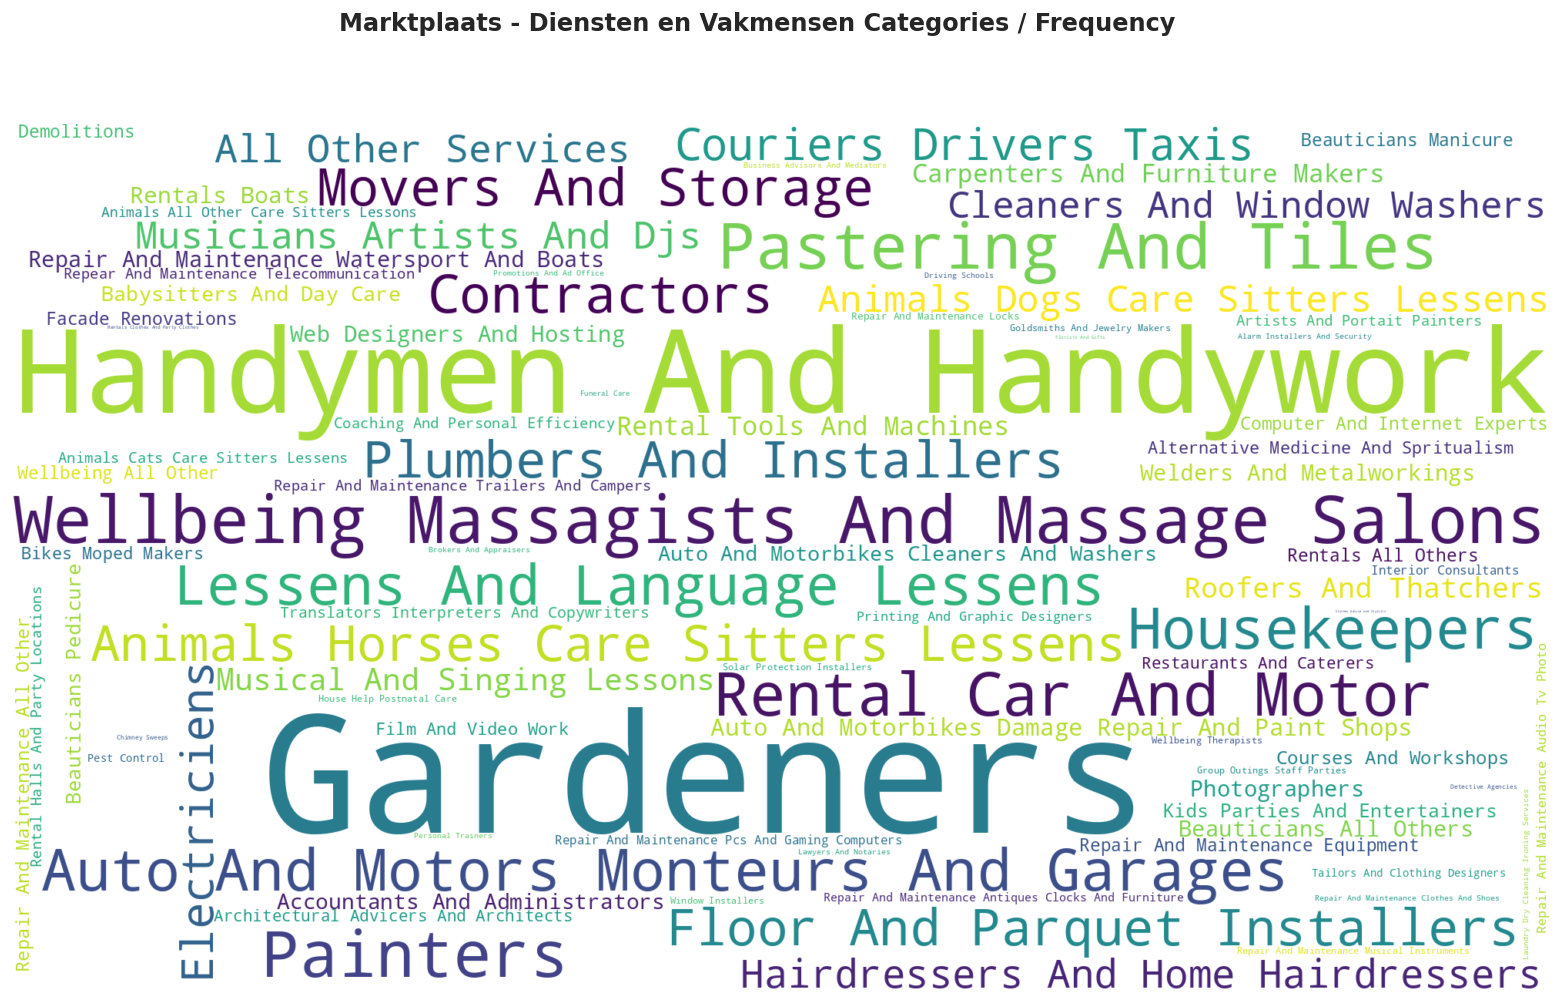

In [47]:
# Generate world cloud of categories by frequency

wc = WordCloud(
    width=GRAPH_PLOT_PX_X,
    height=GRAPH_PLOT_PX_Y,
    background_color="white",
    max_words=len(categories_df.index),
)

wc.generate_from_frequencies(frequencies=categories_freq_dict)

fig = figure("Marktplaats - Diensten en Vakmensen Categories / Frequency")

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Find most popular tags by view count per hour

views_per_hour = []
favorited_per_hour = []

for _, listing in df.iterrows():
    item_id = listing.index

    listed_datetime = parse_datetime(listing["listed_timestamp"])
    crawled_datetime = parse_datetime(listing["crawled_timestamp"])

    diff_datetime = crawled_datetime - listed_datetime
    days, seconds = diff_datetime.days, diff_datetime.seconds
    diff_hours = (days * 24) + (seconds / 3600)

    # if hours is less than 1, assume stats won't change much for 1 hour
    diff_hours = 1 if diff_hours < 1 else diff_hours

    view_count = listing["view_count"]
    view_count_per_hour = view_count / diff_hours

    favorited_count = listing["favorited_count"]
    favorited_count_per_hour = favorited_count / diff_hours

    views_per_hour.append(view_count_per_hour)
    favorited_per_hour.append(favorited_count_per_hour)

df = df.assign(views_per_hour=views_per_hour, favorited_per_hour=favorited_per_hour)
df.sample(5)

In [49]:
types_views_per_hour: dict[str, list[float]] = {}
types_favorited_per_hour: dict[str, list[float]] = {}

types_total_views_per_hour: dict[str, float] = {}
types_total_favorited_per_hour: dict[str, float] = {}

categories_views_per_hour: dict[str, list[float]] = {}
categories_favorited_per_hour: dict[str, list[float]] = {}

categories_total_views_per_hour: dict[str, float] = {}
categories_total_favorited_per_hour: dict[str, float] = {}

for _, listing in df.iterrows():
    views_per_hour = listing["views_per_hour"]
    favorited_per_hour = listing["favorited_per_hour"]

    for type in listing["types"]:
        if type not in types_favorited_per_hour:
            types_views_per_hour[type] = []

        if type not in types_favorited_per_hour:
            types_favorited_per_hour[type] = []

        if type not in types_total_favorited_per_hour:
            types_total_views_per_hour[type] = 0

        if type not in types_total_favorited_per_hour:
            types_total_favorited_per_hour[type] = 0

        types_views_per_hour[type].append(views_per_hour)
        types_total_views_per_hour[type] += views_per_hour

        types_total_favorited_per_hour[type] += favorited_per_hour
        types_favorited_per_hour[type].append(favorited_per_hour)

    category = listing["category_verticals"][-1]

    if category not in categories_views_per_hour:
        categories_views_per_hour[category] = []

    if category not in categories_favorited_per_hour:
        categories_favorited_per_hour[category] = []

    if category not in categories_total_views_per_hour:
        categories_total_views_per_hour[category] = 0

    if category not in categories_total_favorited_per_hour:
        categories_total_favorited_per_hour[category] = 0

    categories_views_per_hour[category].append(views_per_hour)
    categories_favorited_per_hour[category].append(favorited_per_hour)
    categories_total_views_per_hour[category] += views_per_hour
    categories_total_favorited_per_hour[category] += favorited_per_hour

types_median_views_per_hour: dict[str, np.floating] = {}
for type, views_per_hour_list in types_views_per_hour.items():
    types_median_views_per_hour[type] = np.median(views_per_hour_list)

types_median_favorited_per_hour: dict[str, np.floating] = {}
for type, favorited_per_hour_list in types_favorited_per_hour.items():
    types_median_favorited_per_hour[type] = np.median(favorited_per_hour_list)

categories_median_views_per_hour: dict[str, np.floating] = {}
for category, views_per_hour_list in categories_views_per_hour.items():
    categories_median_views_per_hour[category] = np.median(views_per_hour_list)

categories_median_favorited_per_hour: dict[str, np.floating] = {}
for category, favorited_per_hour_list in categories_favorited_per_hour.items():
    categories_median_favorited_per_hour[category] = np.median(favorited_per_hour_list)

In [50]:
types_df["total_views_per_hour"] = types_df["type"].map(types_total_views_per_hour)
types_df["total_favorited_per_hour"] = types_df["type"].map(types_total_favorited_per_hour)

types_df["median_views_per_hour"] = types_df["type"].map(types_median_views_per_hour)
types_df["median_favorited_per_hour"] = types_df["type"].map(types_median_favorited_per_hour)

types_df.sample(10)

,type,frequency,total_views_per_hour,total_favorited_per_hour,median_views_per_hour,median_favorited_per_hour
233,Vervaardiging,13,6.956009,0.405696,0.271546,0.005528
272,Copywriting,6,0.237229,0.001522,0.029224,0.000244
86,Glazenwassen buiten,92,9.610185,0.152478,0.066116,0.000458
46,Snaarinstrumenten,153,4.033523,0.080270,0.013631,0.000133
40,Verhuizen internationaal,195,17.555319,0.411949,0.042467,0.000557
54,Spackspuiten,143,10.051111,0.273299,0.039722,0.000323
177,Massage,29,8.398439,0.271985,0.190832,0.001950
135,Pension of Dagopvang,51,26.880263,1.559924,0.209523,0.004326
13,Behangen,388,35.037323,0.789390,0.041503,0.000564
195,Loopbaanadvies of -begeleiding,22,2.559210,0.036458,0.087515,0.000396


In [51]:
categories_df["total_views_per_hour"] = categories_df["category"].map(
    categories_total_views_per_hour
)
categories_df["total_favorited_per_hour"] = categories_df["category"].map(
    categories_total_favorited_per_hour
)

categories_df["median_views_per_hour"] = categories_df["category"].map(
    categories_median_views_per_hour
)
categories_df["median_favorited_per_hour"] = categories_df["category"].map(
    categories_median_favorited_per_hour
)

categories_df.sample(10)

,name,category,frequency,total_views_per_hour,total_favorited_per_hour,median_views_per_hour,median_favorited_per_hour
14,Electriciens,electriciens,457,0.708414,0.006769,0.007810,0.000066
55,Animals Cats Care Sitters Lessens,animals_cats_care_sitters_lessens,76,0.091208,0.000863,0.022795,0.000175
84,Detective Agencies,detective_agencies,10,0.022549,0.000089,0.011275,0.000044
50,Architectural Advicers And Architects,architectural_advicers_and_architects,87,0.220020,0.002168,0.010196,0.000066
73,Group Outings Staff Parties,group_outings_staff_parties,28,0.081797,0.000298,0.007822,0.000022
83,Funeral Care,funeral_care,12,0.022981,0.000171,0.011490,0.000086
39,Wellbeing All Other,wellbeing_all_other,115,0.138160,0.000687,0.011684,0.000044
27,Photographers,photographers,186,0.162108,0.001217,0.006306,0.000022
40,Repair And Maintenance Equipment,repair_and_maintenance_equipment,115,0.901120,0.010436,0.013099,0.000111
28,Web Designers And Hosting,web_designers_and_hosting,180,0.249853,0.000832,0.004107,0.000022


Text(0, 0.5, 'Type')

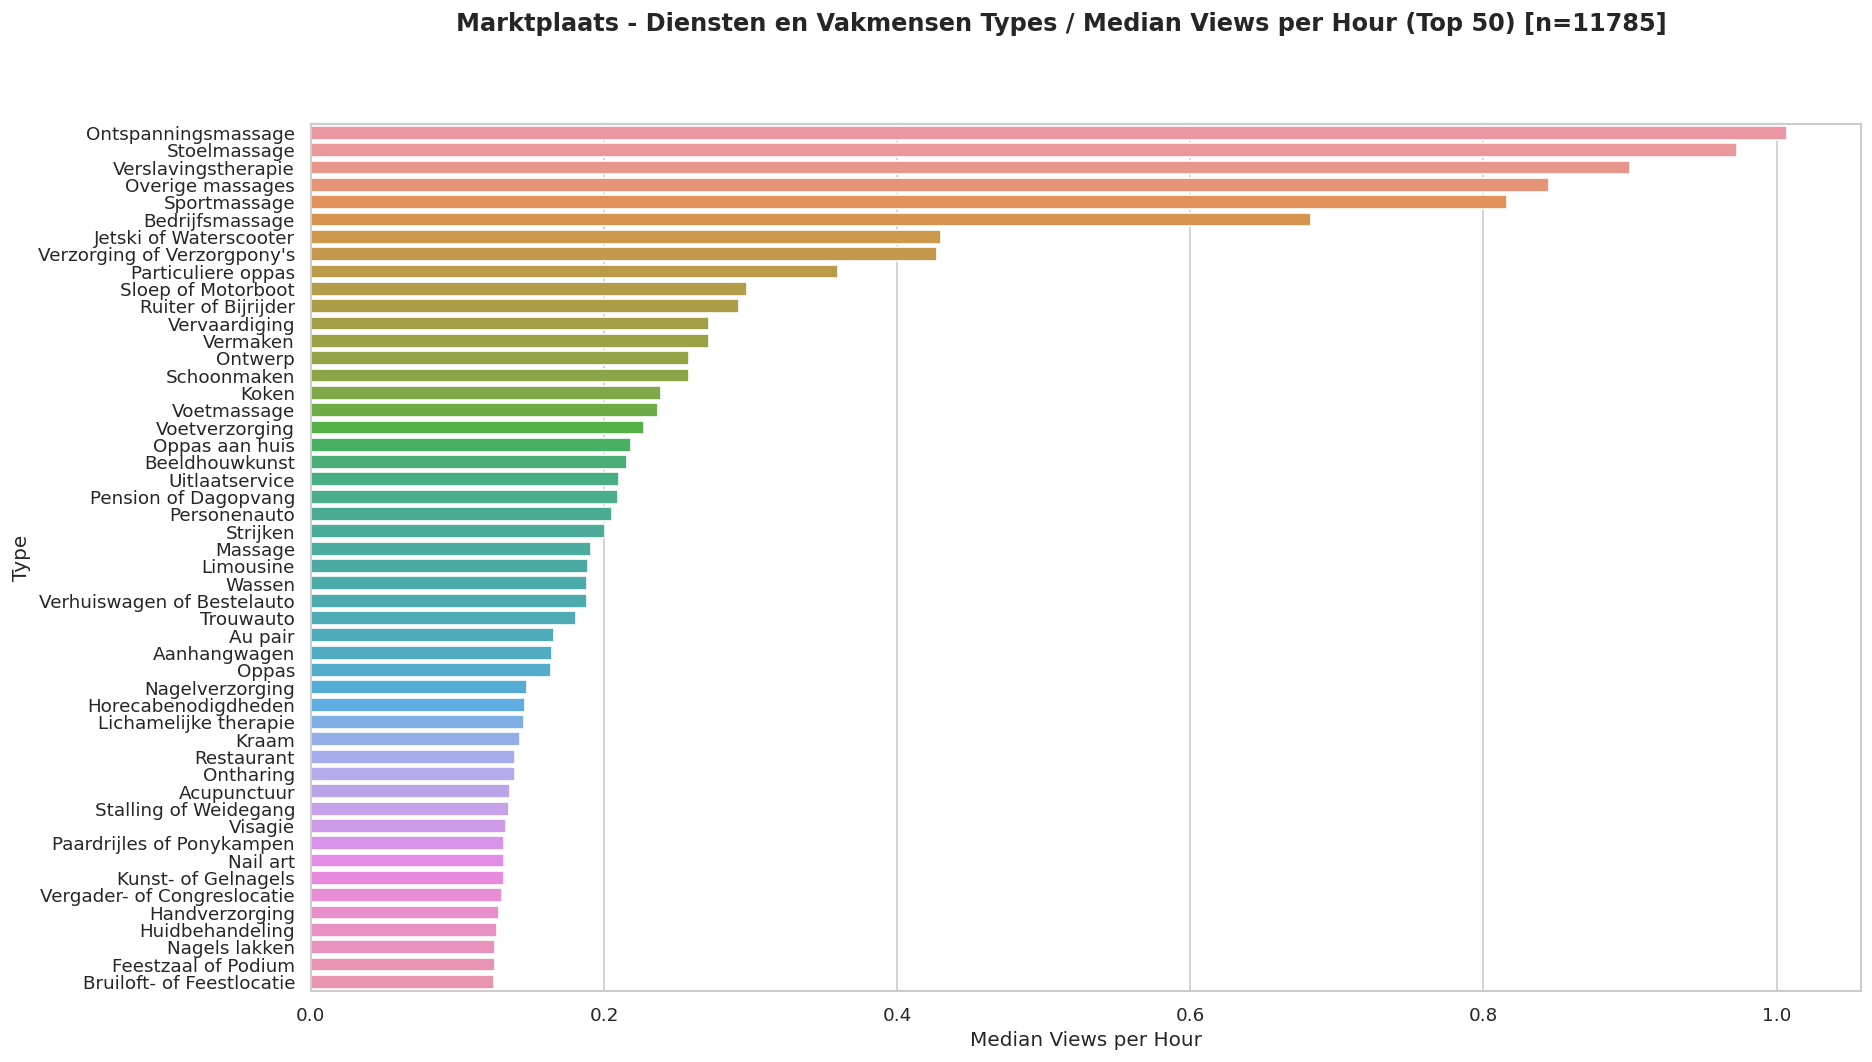

In [52]:
TYPES_VIEWS_N_LARGEST = 50

types_df_largest_views = types_df.nlargest(TYPES_VIEWS_N_LARGEST, "median_views_per_hour")

fig = figure(
    f"Marktplaats - Diensten en Vakmensen Types / Median Views per Hour (Top {TYPES_VIEWS_N_LARGEST}) [n={len(has_types_df.index)}]"
)

sns.barplot(y="type", x="median_views_per_hour", data=types_df_largest_views)

# Add a legend and informative axis label
plt.xlabel("Median Views per Hour")
plt.ylabel("Type")

Text(0, 0.5, 'Type')

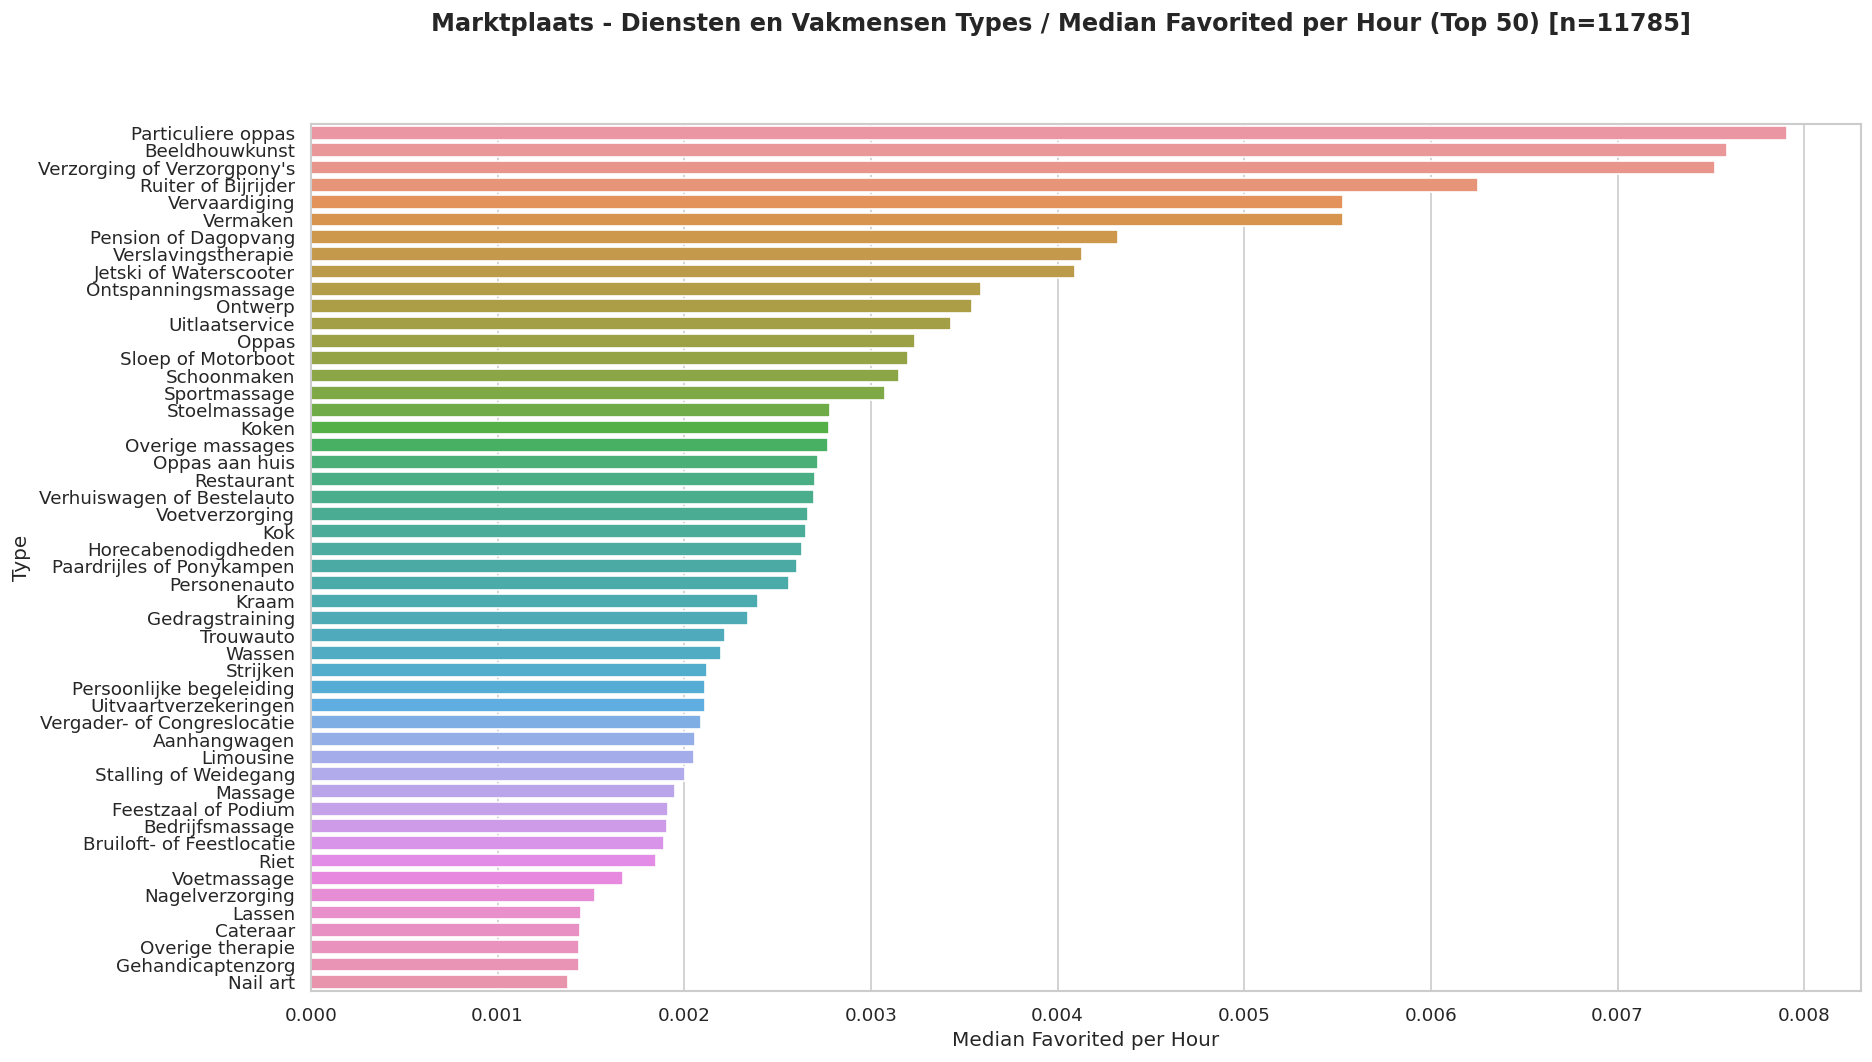

In [53]:
TYPES_FAVORITED_N_LARGEST = 50

types_df_largest_favorited = types_df.nlargest(
    TYPES_FAVORITED_N_LARGEST, "median_favorited_per_hour"
)

fig = figure(
    f"Marktplaats - Diensten en Vakmensen Types / Median Favorited per Hour (Top {TYPES_FAVORITED_N_LARGEST}) [n={len(has_types_df.index)}]"
)

sns.barplot(y="type", x="median_favorited_per_hour", data=types_df_largest_favorited)

# Add a legend and informative axis label
plt.xlabel("Median Favorited per Hour")
plt.ylabel("Type")

Text(0, 0.5, 'Category')

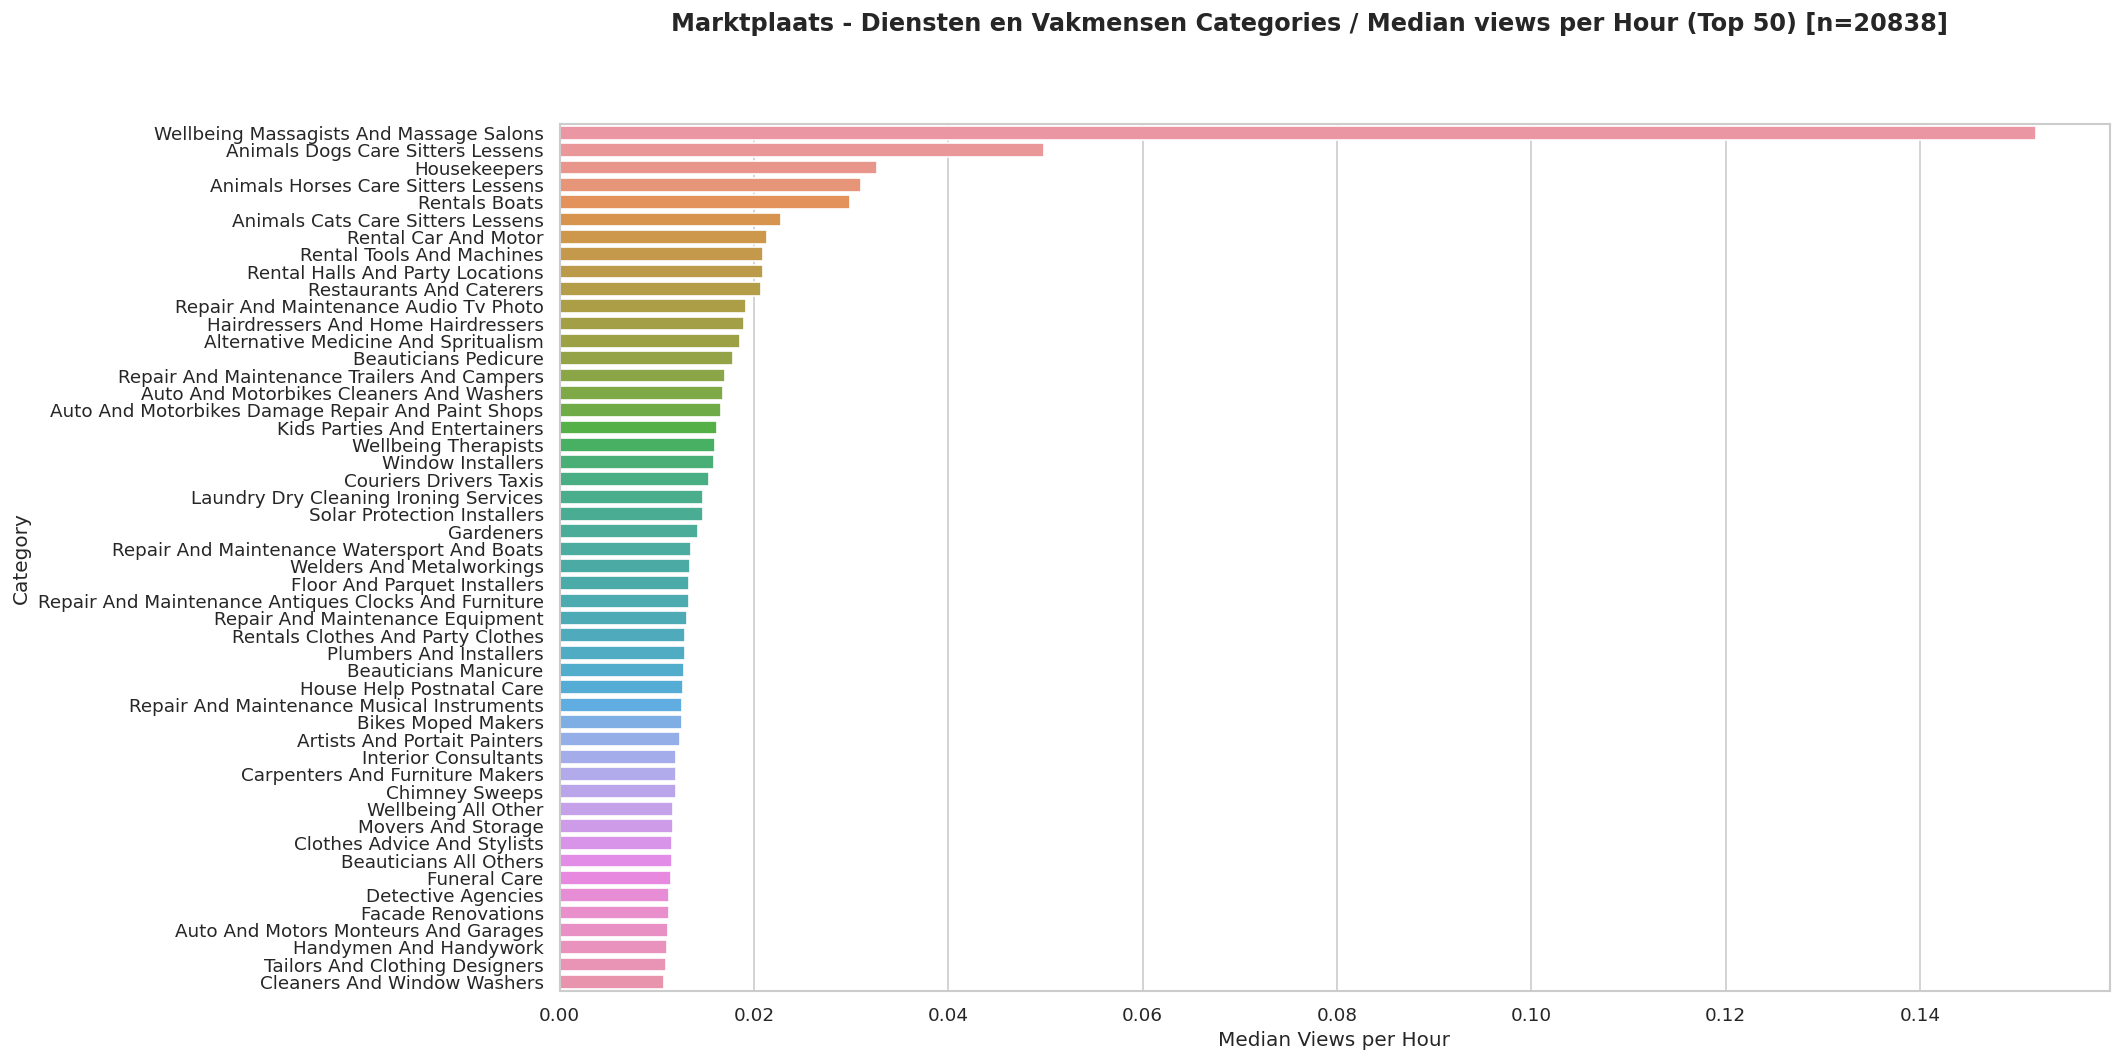

In [54]:
CATEGORIES_VIEWS_N_LARGEST = 50

categories_df_largest_views = categories_df.nlargest(
    CATEGORIES_VIEWS_N_LARGEST, "median_views_per_hour"
)

fig = figure(
    f"Marktplaats - Diensten en Vakmensen Categories / Median views per Hour (Top {CATEGORIES_VIEWS_N_LARGEST}) [n={categories_df.frequency.sum()}]"
)

sns.barplot(y="name", x="median_views_per_hour", data=categories_df_largest_views)

# Add a legend and informative axis label
plt.xlabel("Median Views per Hour")
plt.ylabel("Category")

Text(0, 0.5, 'Category')

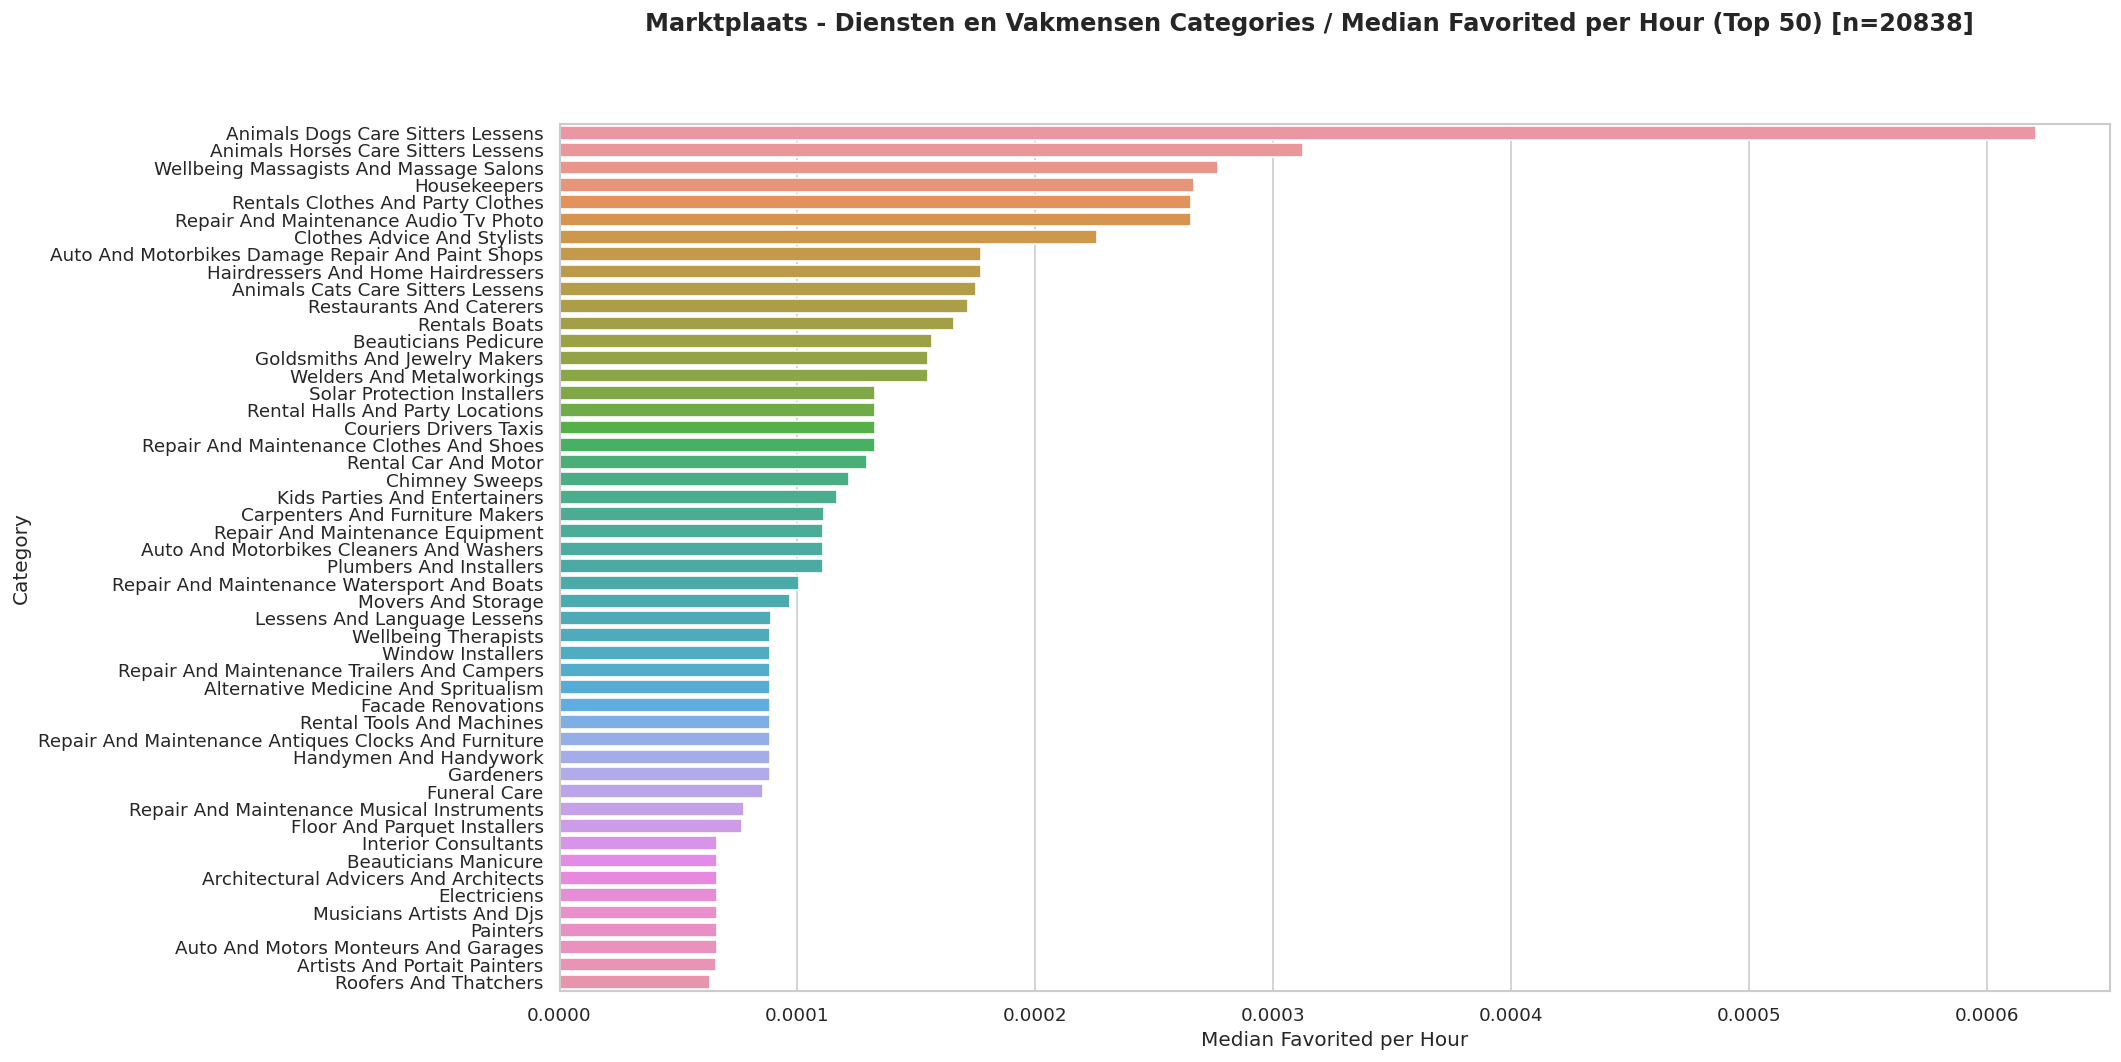

In [55]:
CATEGORIES_FAVORITED_N_LARGEST = 50

categories_df_largest_favorited = categories_df.nlargest(
    CATEGORIES_FAVORITED_N_LARGEST, "median_favorited_per_hour"
)

fig = figure(
    f"Marktplaats - Diensten en Vakmensen Categories / Median Favorited per Hour (Top {CATEGORIES_FAVORITED_N_LARGEST}) [n={categories_df.frequency.sum()}]"
)

sns.barplot(y="name", x="median_favorited_per_hour", data=categories_df_largest_favorited)

# Add a legend and informative axis label
plt.xlabel("Median Favorited per Hour")
plt.ylabel("Category")